In [19]:
%matplotlib inline

# Import Dependencies
import requests
from pprint import pprint
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from decimal import Decimal
import re
import pymongo

<h2>Weekly Box Office Data Scrape, Clean, and Analysis

In [3]:
# Set the weekly box office URL
url = 'https://www.the-numbers.com/weekly-box-office-chart'

# Make the call to the internet page
response = requests.get(url)

# Parse the text version of the response using an html parser 
soup = bs(response.text, 'html.parser')

# Pretty print the parsed text
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <!-- Global site tag (gtag.js) - Google Analytics -->
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-1343128-1">
  </script>
  <script>
   window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-1343128-1');
  </script>
  <meta content='(PICS-1.1 "https://www.icra.org/ratingsv02.html" l gen true for "https://www.the-numbers.com/" r (cb 1 lz 1 nz 1 oz 1 vz 1) "https://www.rsac.org/ratingsv01.html" l gen true for "https://www.the-numbers.com/" r (n 0 s 0 v 0 l 0))' http-equiv="PICS-Label"/>
  <!--<meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1" >-->
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="telephone=no" name="format-detection"/>
  <!-- for apple mobile -->
  <meta content="521546213" property="fb:admins">
   <meta content="initial-scale=1" name="viewport"/>
   <meta content="Weekly (

In [4]:
# Find the tables in the HTML page
all_table_data = soup.find_all('table')

# Isolate only the <tr> tags and subtags within the above table
rows = soup.find_all('tr')

# Start an empty master list of rows
data = []

# Loop through each row
for row in rows:
    # Use <td> to find each cell 
    cols = row.find_all('td')
    # Add the cells to a preliminary list using list comprehensions (this is is for a single row)
    cols = [element.text.strip() for element in cols]
    # Sdd that preliminary list to the master list of rows
    data.append([element for element in cols])

In [10]:
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,← Previous Chart,Chart Index,,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None
2,1,new,The Upside,STX Entertainment,"$28,313,439",,"3,080","$9,193","$28,313,439",1
3,2,(1),Aquaman,Warner Bros.,"$23,410,067",-44%,"3,863","$6,060","$294,006,848",4
4,3,new,A Dogâs Way Home,Sony Pictures,"$14,168,496",,"3,090","$4,585","$14,168,496",1


In [11]:
# Drop first two rows
df.drop([0,1], inplace=True)
df.columns = ["Rank", "Last Rank", "Movie", "Distributor", "Gross", "Change", "Theatres", "Per Theatre", "Total Gross", "Week"]
df.head()

,Rank,Last Rank,Movie,Distributor,Gross,Change,Theatres,Per Theatre,Total Gross,Week
2,1,new,The Upside,STX Entertainment,"$28,313,439",,"3,080","$9,193","$28,313,439",1
3,2,(1),Aquaman,Warner Bros.,"$23,410,067",-44%,"3,863","$6,060","$294,006,848",4
4,3,new,A Dogâs Way Home,Sony Pictures,"$14,168,496",,"3,090","$4,585","$14,168,496",1
5,4,(4),Spider-Man: Into The Spider…,Sony Pictures,"$12,225,940",-32%,"3,029","$4,036","$151,001,385",5
6,5,(2),Escape Room,Sony Pictures,"$11,893,017",-49%,"2,717","$4,377","$35,425,948",2


In [13]:
# Make a copy of dataframe
new_df = df.copy()

# Remove all dollar signs
new_df['Gross'] = [x.strip('$') for x in df['Gross']]
new_df['Per Theatre'] = [x.strip('$') for x in df['Per Theatre']]
new_df['Total Gross'] = [x.strip('$') for x in df['Total Gross']]

new_df.head()

,Rank,Last Rank,Movie,Distributor,Gross,Change,Theatres,Per Theatre,Total Gross,Week
2,1,new,The Upside,STX Entertainment,"28,313,439",,"3,080","9,193","28,313,439",1
3,2,(1),Aquaman,Warner Bros.,"23,410,067",-44%,"3,863","6,060","294,006,848",4
4,3,new,A Dogâs Way Home,Sony Pictures,"14,168,496",,"3,090","4,585","14,168,496",1
5,4,(4),Spider-Man: Into The Spider…,Sony Pictures,"12,225,940",-32%,"3,029","4,036","151,001,385",5
6,5,(2),Escape Room,Sony Pictures,"11,893,017",-49%,"2,717","4,377","35,425,948",2


In [14]:
# Remove all commas and create new clean dataframe
new_df['Gross'] = new_df['Gross'].str.replace(',', '')
new_df['Theatres'] = new_df['Theatres'].str.replace(',', '')
new_df['Total Gross'] = new_df['Total Gross'].str.replace(',', '')
new_df.head()

,Rank,Last Rank,Movie,Distributor,Gross,Change,Theatres,Per Theatre,Total Gross,Week
2,1,new,The Upside,STX Entertainment,28313439,,3080,"9,193",28313439,1
3,2,(1),Aquaman,Warner Bros.,23410067,-44%,3863,"6,060",294006848,4
4,3,new,A Dogâs Way Home,Sony Pictures,14168496,,3090,"4,585",14168496,1
5,4,(4),Spider-Man: Into The Spider…,Sony Pictures,12225940,-32%,3029,"4,036",151001385,5
6,5,(2),Escape Room,Sony Pictures,11893017,-49%,2717,"4,377",35425948,2


In [15]:
# Create new dataframe isolating movie, distributor, total gross revenue
movie_gross_df = new_df[["Movie", "Distributor", "Total Gross"]]
movie_gross_df.head()

,Movie,Distributor,Total Gross
2,The Upside,STX Entertainment,28313439
3,Aquaman,Warner Bros.,294006848
4,A Dogâs Way Home,Sony Pictures,14168496
5,Spider-Man: Into The Spider…,Sony Pictures,151001385
6,Escape Room,Sony Pictures,35425948


In [16]:
dist_gross_count = movie_gross_df.groupby("Distributor").count()["Total Gross"]
dist_gross_count.head()

Distributor
20th Century Fox      4
Amazon Studios        2
Annapurna Pictures    3
CBS Films             1
Distrib Films         2
Name: Total Gross, dtype: int64

In [17]:
dist_gross_sum = movie_gross_df.groupby("Distributor").sum()["Total Gross"]
dist_gross_sum.head()

Distributor
20th Century Fox      1997324844227083329719483324586848
Amazon Studios                             4548337628832
Annapurna Pictures                 373833638815560486084
CBS Films                                        2129757
Distrib Films                                  292835381
Name: Total Gross, dtype: object

In [18]:
# Combine the data into a single dataset using pandas merge
merged_df = pd.DataFrame(
    data={"Total Gross All Movies": dist_gross_sum,
          "# of Movies": dist_gross_count,
    }
)
merged_df.head()

,Total Gross All Movies,# of Movies
Distributor,,
20th Century Fox,1997324844227083329719483324586848,4
Amazon Studios,4548337628832,2
Annapurna Pictures,373833638815560486084,3
CBS Films,2129757,1
Distrib Films,292835381,2


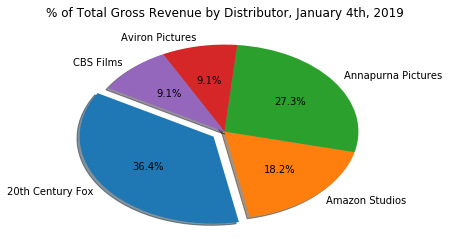

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise
labels = '20th Century Fox', 'Amazon Studios', 'Annapurna Pictures', 'Aviron Pictures', 'CBS Films'
sizes = [4, 2, 3, 1, 1]
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 1st slice (i.e. '20th Century Fox')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        explode=explode, shadow=True, startangle=150)

plt.title("% of Total Gross Revenue by Distributor, January 4th, 2019")

# Save Figure
plt.savefig('fig1.png')

plt.show()

In [20]:
twentieth_c_fox = new_df[new_df["Distributor"] == "20th Century Fox"]
twentieth_c_fox

,Rank,Last Rank,Movie,Distributor,Gross,Change,Theatres,Per Theatre,Total Gross,Week
13,12,(11),Bohemian Rhapsody,20th Century Fox,4436178,+10%,1334,"3,325",199732484,11
35,34,(28),Widows,20th Century Fox,108693,-37%,108,"1,006",42270833,9
46,45,(46),The Hate U Give,20th Century Fox,14483,-33%,31,467,29719483,15
48,47,(42),Once Upon a Deadpool,20th Century Fox,12331,-68%,33,374,324586848,35


In [21]:
twentieth_c_fox["Movie"]

13       Bohemian Rhapsody
35                  Widows
46         The Hate U Give
48    Once Upon a Deadpool
Name: Movie, dtype: object

In [22]:
twentieth_c_fox["Total Gross"]

13    199732484
35     42270833
46     29719483
48    324586848
Name: Total Gross, dtype: object

In [23]:
# isolated dataset for twentieth century fox releases
movies = ["Bohemian Rhapsody", "Widows", "Once Upon a Deadpool", "The Hate U Give"]
total_gross = [195296306, 42162140, 324574517, 29705000] 

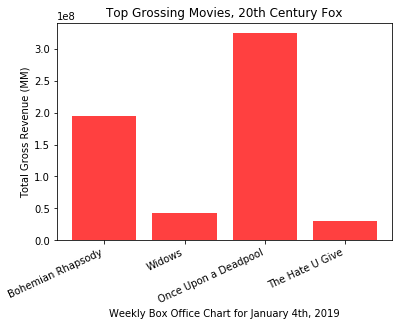

In [24]:
x_axis = np.arange(0, len(movies))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)

plt.title("Top Grossing Movies, 20th Century Fox")
plt.xlabel("Weekly Box Office Chart for January 4th, 2019")
plt.ylabel("Total Gross Revenue (MM)")

plt.bar(x_axis, total_gross, facecolor="red", alpha=0.75, align="center")
plt.xticks(tick_locations, movies,  ha='right', rotation=25)

# Save Figure
plt.savefig('fig2.png', bbox_inches="tight", dpi=199)

plt.show()

In [31]:
# Call the 'to_dict' function on the new_df dataframe 
# Pass the argument'records' to translate each row of the df into a dictionary
data = new_df.to_dict("records")
data

[{'Rank': '1',
  'Last Rank': 'new',
  'Movie': 'The Upside',
  'Distributor': 'STX Entertainment',
  'Gross': '28313439',
  'Change': '',
  'Theatres': '3080',
  'Per Theatre': '9,193',
  'Total Gross': '28313439',
  'Week': '1'},
 {'Rank': '2',
  'Last Rank': '(1)',
  'Movie': 'Aquaman',
  'Distributor': 'Warner Bros.',
  'Gross': '23410067',
  'Change': '-44%',
  'Theatres': '3863',
  'Per Theatre': '6,060',
  'Total Gross': '294006848',
  'Week': '4'},
 {'Rank': '3',
  'Last Rank': 'new',
  'Movie': 'A Dogâ\x80\x99s Way Home',
  'Distributor': 'Sony Pictures',
  'Gross': '14168496',
  'Change': '',
  'Theatres': '3090',
  'Per Theatre': '4,585',
  'Total Gross': '14168496',
  'Week': '1'},
 {'Rank': '4',
  'Last Rank': '(4)',
  'Movie': 'Spider-Man: Into The Spider…',
  'Distributor': 'Sony Pictures',
  'Gross': '12225940',
  'Change': '-32%',
  'Theatres': '3029',
  'Per Theatre': '4,036',
  'Total Gross': '151001385',
  'Week': '5'},
 {'Rank': '5',
  'Last Rank': '(2)',
  'Movie'

<h2>Insert Into MongoDB

In [15]:
conn = "mongodb://127.0.0.1:27017"
client = pymongo.MongoClient(conn)
db = client["movies"]
db.weeklyboxoffice.insert_many(data)
weeklyboxoffice_data = db.weeklyboxoffice.find()
for data in weeklyboxoffice_data:
    pprint(data)

{'_id': ObjectId('5c40edf7b520d908e3723b79'),
 'critic_score': '81',
 'director': 'J.J. Abrams',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
 'main_cast': ['Adam Driver',
               ' Carrie Fisher',
               ' Daisy Ridley',
               ' Domhnall Gleeson',
               ' Harrison Ford',
               ' John Boyega',
               ' Mark Hamill',
               ' Oscar Isaac'],
 'parental_rating': 'PG-13',
 'release_date': 'December 18, 2015',
 'runtime': '135 min',
 'studio': 'Walt Disney Studios Motion Pictures',
 'title': 'Star Wars Ep. VII: The Force Awakens',
 'user_score': '6.8'}
{'_id': ObjectId('5c40edf7b520d908e3723b7a'),
 'critic_score': '83',
 'director': 'James Cameron',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
 'main_cast': ['Michelle Rodriguez', ' Sam Worthington', ' Sigourney Weaver'],
 'parental_rating': 'PG-13',
 'release_date': 'December 18, 2009',
 'runtime': '162 min',
 'studio': 'Twentieth Century Fox Film Corporation'

 'title': 'Star Wars Ep. V: The Empire Strikes Back',
 'user_score': '9.0'}
{'_id': ObjectId('5c40edf7b520d908e3723bd3'),
 'critic_score': '81',
 'director': 'Mike Newell',
 'genres': ['Adventure', 'Mystery', 'Fantasy', 'Family'],
 'main_cast': ['Daniel Radcliffe', ' Emma Watson', ' Rupert Grint'],
 'parental_rating': 'PG-13',
 'release_date': 'November 18, 2005',
 'runtime': '157 min',
 'studio': 'Warner Bros. Pictures',
 'title': 'Harry Potter and the Goblet of Fire',
 'user_score': '7.9'}
{'_id': ObjectId('5c40edf7b520d908e3723bd4'),
 'critic_score': '78',
 'director': 'David Silverman and Lee Unkrich and Pete Docter',
 'genres': ['Adventure', 'Fantasy', 'Comedy', 'Animation', 'Family'],
 'main_cast': ['Billy Crystal', ' John Goodman'],
 'parental_rating': 'TV-G',
 'release_date': 'November 2, 2001',
 'runtime': '92 min',
 'studio': 'Buena Vista Pictures',
 'title': 'Monsters, Inc.',
 'user_score': '8.7'}
{'_id': ObjectId('5c40edf7b520d908e3723bd5'),
 'critic_score': '63',
 'directo

 'title': 'Furious 7',
 'user_score': '6.8'}
{'_id': ObjectId('5c429716b520d9176120ac92'),
 'critic_score': '42',
 'director': 'Michael Bay',
 'genres': ['Action', 'Adventure', 'Sci-Fi'],
 'main_cast': ['Josh Duhamel',
               ' Rosie Huntington-Whiteley',
               ' Shia LaBeouf',
               ' Tyrese Gibson'],
 'parental_rating': 'PG-13',
 'release_date': 'June 29, 2011',
 'runtime': '154 min',
 'studio': 'Paramount Pictures',
 'title': 'Transformers: Dark of the Moon',
 'user_score': '5.7'}
{'_id': ObjectId('5c429716b520d9176120ac93'),
 'critic_score': '72',
 'director': 'Clint Eastwood',
 'genres': ['Action', 'Biography', 'Drama', 'War'],
 'main_cast': ['Bradley Cooper', ' Sienna Miller'],
 'parental_rating': 'R',
 'release_date': 'December 25, 2014',
 'runtime': '132 min',
 'studio': 'Warner Bros. Pictures',
 'title': 'American Sniper',
 'user_score': '6.6'}
{'_id': ObjectId('5c429716b520d9176120ac94'),
 'critic_score': '87',
 'director': 'Peter Jackson',
 'genres'

 'critic_score': '76',
 'director': 'Francis Lawrence',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Drama', 'Thriller'],
 'main_cast': ['Jennifer Lawrence',
               ' Josh Hutcherson',
               ' Liam Hemsworth',
               ' Philip Seymour Hoffman'],
 'parental_rating': 'PG-13',
 'release_date': 'November 22, 2013',
 'runtime': '146 min',
 'studio': 'Lionsgate',
 'title': 'The Hunger Games: Catching Fire',
 'user_score': '7.9'}
{'_id': ObjectId('5c429c06b520d918693d35b9'),
 'critic_score': '53',
 'director': 'Gore Verbinski',
 'genres': ['Action', 'Adventure', 'Fantasy'],
 'main_cast': ['Johnny Depp', ' Keira Knightley', ' Orlando Bloom'],
 'parental_rating': 'PG-13',
 'release_date': 'July 7, 2006',
 'runtime': '151 min',
 'studio': 'American Broadcasting Company (ABC)',
 'title': 'Pirates of the Caribbean: Dead Manâ\x80\x99s Chest',
 'user_score': '7.2'}
{'_id': ObjectId('5c429c06b520d918693d35ba'),
 'critic_score': '83',
 'director': 'Rob Minkoff and Roger Allers

 'director': 'Francis Lawrence',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Drama', 'Thriller', 'War'],
 'main_cast': ['Donald Sutherland',
               ' Elizabeth Banks',
               ' Jennifer Lawrence',
               ' Josh Hutcherson',
               ' Julianne Moore',
               ' Liam Hemsworth',
               ' Philip Seymour Hoffman',
               ' Sam Claflin',
               ' Willow Shields',
               ' Woody Harrelson'],
 'parental_rating': 'PG-13',
 'release_date': 'November 20, 2015',
 'runtime': '137 min',
 'studio': 'Lionsgate',
 'title': 'The Hunger Games: Mockingjay - Part 2',
 'user_score': '6.7'}
{'_id': ObjectId('5c429c06b520d918693d3603'),
 'critic_score': '62',
 'director': 'Andy Wachowski and Lana Wachowski',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'],
 'main_cast': '',
 'parental_rating': 'R',
 'release_date': 'May 15, 2003',
 'runtime': '138 min',
 'studio': 'Warner Bros. Pictures',
 'title': 'The Matrix Reloaded',
 'user_

               ' Sophia Lillis',
               ' Steven Williams',
               ' Wyatt Oleff'],
 'parental_rating': 'R',
 'release_date': 'September 8, 2017',
 'runtime': '135 min',
 'studio': 'New Line Cinema',
 'title': 'It',
 'user_score': '7.8',
 'year': '2017'}
{'_id': ObjectId('5c42aa27b520d9193db477a5'),
 'critic_score': '40',
 'director': 'David Ayer',
 'genres': ['Action',
            'Adventure',
            'Sci-Fi',
            'Thriller',
            'Fantasy',
            'Comedy',
            'Crime'],
 'main_cast': ['Jared Leto', ' Margot Robbie', ' Viola Davis', ' Will Smith'],
 'parental_rating': 'PG-13',
 'release_date': 'August 5, 2016',
 'runtime': '123 min',
 'studio': 'Warner Bros.',
 'title': 'Suicide Squad',
 'user_score': '6.1',
 'year': '2016'}
{'_id': ObjectId('5c42aa27b520d9193db477a6'),
 'critic_score': '66',
 'director': 'David Leitch',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Comedy'],
 'main_cast': ['Bill Skarsgård',
               ' Brad Pitt'

<h2>Scraping Metacritic Scores

In [2]:
# Try Metacritic Scrape for Top 100 Ranked Movies
url = 'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?sort=desc'
print(requests.get(url))

<Response [403]>


In [3]:
# Add headers to bypass 403 Forbidden Access
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15'}
response = requests.get(url, timeout=30, headers=headers)
print(response)

<Response [200]>


In [4]:
# Parse the HTML text using Beautiful Soup
soup = bs(response.text, 'html.parser')

# Find and append the metacritic score, rank, title, and short summary of each movie
top_100_metacritic_dicts = []
for td in soup.find_all('td', class_ = 'clamp-summary-wrap'):
    score = td.find('div', class_ = 'clamp-score-wrap').text.strip()
    rank = td.find('span', class_ = 'title numbered').text.strip()[:-1]
    title = td.find('a', class_ = 'title').text.strip()
    summary = td.find('div', class_ = 'summary').text.strip()
    top_100_metacritic_dicts.append({'score': score,
                                    'rank': rank,
                                    'title': title,
                                    'summary': summary})

print(len(top_100_metacritic_dicts))

100


<h2>Scraping Base Data (Top 100 Grossing Movies)

In [5]:
# Scrape the base data from the-numbers.com (for Top 100 Grossing Movies)
response = requests.get("https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time")
base_df_1 = pd.read_html(response.text)[0]
base_df_2 = pd.read_html(response.text)[1]
base_df = base_df_1.append(base_df_2).reset_index(drop=True)

# Fix cut off titles
base_df = base_df.replace(base_df.iloc[74]['Movie'], 'Pirates of the Caribbean: The Curse of the Black Pearl')
base_df = base_df.replace(base_df.iloc[87]['Movie'], 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe')

base_df = base_df.rename(columns = {"Movie":"title", "Released": "year"})

# Make a copy of dataframe
base_df2 = base_df.copy()

# Loop through copy of dataframe and convert money text to decimal formatting
for index, row in base_df2.iterrows():
    # Convert to decimal
    money = re.match(r'\$\d+,\d+,\d+', row['DomesticBox Office']).group()
    base_df2 = base_df2.replace(row['DomesticBox Office'], Decimal(re.sub(r'[^\d.]', '', money)))
    money = re.match(r'\$\d+,\d+,\d+', row['InternationalBox Office']).group()
    base_df2 = base_df2.replace(row['InternationalBox Office'], Decimal(re.sub(r'[^\d.]', '', money)))
    money = re.match(r'\$\d+,\d+,\d+', row['WorldwideBox Office']).group()
    base_df2 = base_df2.replace(row['WorldwideBox Office'], Decimal(re.sub(r'[^\d.]', '', money)))

base_df2.head()

,Rank,year,title,DomesticBox Office,InternationalBox Office,WorldwideBox Office
0,1,2015,Star Wars Ep. VII: The Force Awakens,936662225,1116648,2053311
1,2,2009,Avatar,760507625,2015837,2776345
2,3,2018,Black Panther,700059566,648300000,1348359
3,4,2018,Avengers: Infinity War,678815482,1369988,2048803
4,5,1997,Titanic,659363944,1548844,2208208


<h2>Scraping Base Data Movies (Top 100 Grossing Movies) from Metacritic

In [6]:
# Prepare Movie Title URLs for Metacritic calls
urls = []

for index, row in base_df.iterrows():
    
    title = row['title']
    year = row['year']

    url_title = title.replace(' ', '-').replace(',', '').lower().replace('â', '')

    # Replace 'ep.'' with 'episode' and the ':' trailing the number with '--'
    if 'ep.' in url_title:
        m = re.match('(.+)(ep\.)(-[iv]+)(:)(.+)', url_title)
        group1, group2, group3, group4, group5 = m.group(1), m.group(2), m.group(3), m.group(4), m.group(5)
        url_title = group1 + 'episode' + group3 + '--' + group5
    
    # Now replace ':' and '.' with '' since we don't need it for matching anymore
    if ':' in url_title:
        url_title = url_title.replace(':', '')
    if '.' in url_title:
        url_title = url_title.replace('.', '')

    # Special cases of URLs that do not follow the same formatting as the majority:
    if 'The Avengers' in title or 'Beauty and the Beast' in title or 'Frozen' in title \
        or 'The Jungle Book' in title or 'Inside Out' in title:
        url_title = url_title + '-' + str(year)
    if 'part-ii' in url_title in url_title:
        url_title = url_title.replace('part-ii', 'part-2')
    if 'Breaking Dawn' in title:
        url_title = url_title.split('part')[0] + '--part' + url_title.split('part')[1]
        
    urls.append({'title': title, 'year': year, 'url': 'https://www.metacritic.com/movie/' + url_title})
    
len(urls)

100

In [7]:
# Scraping Metacritic for each of the top 100 grossing movies
top_100_grossing_metacritic_dicts = []

for url in urls:

    # Parse the HTML text using Beautiful Soup
    soup = bs(requests.get(url['url'], timeout=30, headers=headers).text, 'html.parser')
    
    # Find and append the release date, metacritic critic(meta) and user scores, production studio, 
    # diretor, main cast, genres, and parental rating, and runtime of each movie
    
    # Release Date
    try:
        for span in soup.find_all('span', class_ = 'release_date'):
            release_date = span.find_all('span')[1].text.strip()
            release_year = release_date[-4:]
    except:
        release_date = ''
    # Scores
    try:
        #critic_score = soup.find('div', class_ = 'primary_baby_item oswald').text.strip().split('\n')[0]
        #critic_score = soup.find('div', class_ = 'score fl').text.strip()
        scores = []
        for a in soup.find_all('a', class_ = 'metascore_anchor'):
            scores.append(a.text.strip())
        critic_score = scores[0]
        user_score = scores[1]
    except:
        critic_score = ''
        user_score = ''
        print(url['url'])
        
    # Production Studio
    try:
        studio = soup.find('span', class_ = 'distributor').text.strip()[:-2]
    except:
        studio = ''
        
    # Director
    try:
        director = soup.find('div', class_ = 'director').text.strip().split('\n')[1]
    except:
        director = ''
        
    # Main Cast
    try:
        main_cast = soup.find('div', class_ = 'summary_cast details_section').text.strip().split('\n')[2].replace('  ', '').split(',')
    except:
        main_cast = ''
    
    # Genres
    try:
        genres = soup.find('div', class_ = 'genres').text.strip()[11:].replace(' ', '').split(',')
    except:
        genres = ''
    
    # Parental Rating
    try:
        parental_rating = soup.find('div', class_ = 'rating').text.strip().split('\n')[3].replace('  ', '')
    except:
        parental_rating = ''

    # Runtime
    try:
        runtime = soup.find('div', class_ = 'runtime').text.strip()[9:]
    except:
        runtime = ''
    
    # Append data as a dictionary to list of dictionaries
    top_100_grossing_metacritic_dicts.append({'title': url['title'],
                                              'year': release_year,
                                              'release_date': release_date,
                                              'critic_score': critic_score,
                                              'user_score': user_score,
                                              'studio': studio,
                                              'director': director,
                                              'main_cast': main_cast,
                                              'genres': genres,
                                              'parental_rating': parental_rating,
                                              'runtime': runtime
                                             })

pprint(top_100_grossing_metacritic_dicts)

[{'critic_score': '81',
  'director': 'J.J. Abrams',
  'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
  'main_cast': ['Adam Driver',
                ' Carrie Fisher',
                ' Daisy Ridley',
                ' Domhnall Gleeson',
                ' Harrison Ford',
                ' John Boyega',
                ' Mark Hamill',
                ' Oscar Isaac'],
  'parental_rating': 'PG-13',
  'release_date': 'December 18, 2015',
  'runtime': '135 min',
  'studio': 'Walt Disney Studios Motion Pictures',
  'title': 'Star Wars Ep. VII: The Force Awakens',
  'user_score': '6.8',
  'year': '2015'},
 {'critic_score': '83',
  'director': 'James Cameron',
  'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
  'main_cast': ['Michelle Rodriguez', ' Sam Worthington', ' Sigourney Weaver'],
  'parental_rating': 'PG-13',
  'release_date': 'December 18, 2009',
  'runtime': '162 min',
  'studio': 'Twentieth Century Fox Film Corporation',
  'title': 'Avatar',
  'user_score': '7.5',
  

  'title': 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
  'user_score': '5.8',
  'year': '2005'},
 {'critic_score': '55',
  'director': 'Zack Snyder',
  'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
  'main_cast': ['Amy Adams',
                ' Antje Traue',
                ' Christopher Meloni',
                ' Diane Lane',
                ' Harry Lennix',
                ' Henry Cavill',
                ' Michael Shannon',
                ' Richard Schiff',
                ' Russell Crowe'],
  'parental_rating': 'PG-13',
  'release_date': 'June 14, 2013',
  'runtime': '143 min',
  'studio': 'Warner Bros. Pictures',
  'title': 'Man of Steel',
  'user_score': '7.5',
  'year': '2013'},
 {'critic_score': '82',
  'director': 'Irvin Kershner',
  'genres': ['Action', 'Adventure', 'Sci-Fi'],
  'main_cast': ['Carrie Fisher', ' Harrison Ford', ' Mark Hamill'],
  'parental_rating': 'PG',
  'release_date': 'May 21, 1980',
  'runtime': '124 min',
  'studio': 'Twe

<h2>Insert Into MongoDB

In [15]:
db.metacritic.insert_many(top_100_grossing_metacritic_dicts)
metacritic_data = db.metacritic.find()
for data in metacritic_data:
    pprint(data)

{'_id': ObjectId('5c40edf7b520d908e3723b79'),
 'critic_score': '81',
 'director': 'J.J. Abrams',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
 'main_cast': ['Adam Driver',
               ' Carrie Fisher',
               ' Daisy Ridley',
               ' Domhnall Gleeson',
               ' Harrison Ford',
               ' John Boyega',
               ' Mark Hamill',
               ' Oscar Isaac'],
 'parental_rating': 'PG-13',
 'release_date': 'December 18, 2015',
 'runtime': '135 min',
 'studio': 'Walt Disney Studios Motion Pictures',
 'title': 'Star Wars Ep. VII: The Force Awakens',
 'user_score': '6.8'}
{'_id': ObjectId('5c40edf7b520d908e3723b7a'),
 'critic_score': '83',
 'director': 'James Cameron',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Fantasy'],
 'main_cast': ['Michelle Rodriguez', ' Sam Worthington', ' Sigourney Weaver'],
 'parental_rating': 'PG-13',
 'release_date': 'December 18, 2009',
 'runtime': '162 min',
 'studio': 'Twentieth Century Fox Film Corporation'

 'title': 'Star Wars Ep. V: The Empire Strikes Back',
 'user_score': '9.0'}
{'_id': ObjectId('5c40edf7b520d908e3723bd3'),
 'critic_score': '81',
 'director': 'Mike Newell',
 'genres': ['Adventure', 'Mystery', 'Fantasy', 'Family'],
 'main_cast': ['Daniel Radcliffe', ' Emma Watson', ' Rupert Grint'],
 'parental_rating': 'PG-13',
 'release_date': 'November 18, 2005',
 'runtime': '157 min',
 'studio': 'Warner Bros. Pictures',
 'title': 'Harry Potter and the Goblet of Fire',
 'user_score': '7.9'}
{'_id': ObjectId('5c40edf7b520d908e3723bd4'),
 'critic_score': '78',
 'director': 'David Silverman and Lee Unkrich and Pete Docter',
 'genres': ['Adventure', 'Fantasy', 'Comedy', 'Animation', 'Family'],
 'main_cast': ['Billy Crystal', ' John Goodman'],
 'parental_rating': 'TV-G',
 'release_date': 'November 2, 2001',
 'runtime': '92 min',
 'studio': 'Buena Vista Pictures',
 'title': 'Monsters, Inc.',
 'user_score': '8.7'}
{'_id': ObjectId('5c40edf7b520d908e3723bd5'),
 'critic_score': '63',
 'directo

 'title': 'Furious 7',
 'user_score': '6.8'}
{'_id': ObjectId('5c429716b520d9176120ac92'),
 'critic_score': '42',
 'director': 'Michael Bay',
 'genres': ['Action', 'Adventure', 'Sci-Fi'],
 'main_cast': ['Josh Duhamel',
               ' Rosie Huntington-Whiteley',
               ' Shia LaBeouf',
               ' Tyrese Gibson'],
 'parental_rating': 'PG-13',
 'release_date': 'June 29, 2011',
 'runtime': '154 min',
 'studio': 'Paramount Pictures',
 'title': 'Transformers: Dark of the Moon',
 'user_score': '5.7'}
{'_id': ObjectId('5c429716b520d9176120ac93'),
 'critic_score': '72',
 'director': 'Clint Eastwood',
 'genres': ['Action', 'Biography', 'Drama', 'War'],
 'main_cast': ['Bradley Cooper', ' Sienna Miller'],
 'parental_rating': 'R',
 'release_date': 'December 25, 2014',
 'runtime': '132 min',
 'studio': 'Warner Bros. Pictures',
 'title': 'American Sniper',
 'user_score': '6.6'}
{'_id': ObjectId('5c429716b520d9176120ac94'),
 'critic_score': '87',
 'director': 'Peter Jackson',
 'genres'

 'critic_score': '76',
 'director': 'Francis Lawrence',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Drama', 'Thriller'],
 'main_cast': ['Jennifer Lawrence',
               ' Josh Hutcherson',
               ' Liam Hemsworth',
               ' Philip Seymour Hoffman'],
 'parental_rating': 'PG-13',
 'release_date': 'November 22, 2013',
 'runtime': '146 min',
 'studio': 'Lionsgate',
 'title': 'The Hunger Games: Catching Fire',
 'user_score': '7.9'}
{'_id': ObjectId('5c429c06b520d918693d35b9'),
 'critic_score': '53',
 'director': 'Gore Verbinski',
 'genres': ['Action', 'Adventure', 'Fantasy'],
 'main_cast': ['Johnny Depp', ' Keira Knightley', ' Orlando Bloom'],
 'parental_rating': 'PG-13',
 'release_date': 'July 7, 2006',
 'runtime': '151 min',
 'studio': 'American Broadcasting Company (ABC)',
 'title': 'Pirates of the Caribbean: Dead Manâ\x80\x99s Chest',
 'user_score': '7.2'}
{'_id': ObjectId('5c429c06b520d918693d35ba'),
 'critic_score': '83',
 'director': 'Rob Minkoff and Roger Allers

 'director': 'Francis Lawrence',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Drama', 'Thriller', 'War'],
 'main_cast': ['Donald Sutherland',
               ' Elizabeth Banks',
               ' Jennifer Lawrence',
               ' Josh Hutcherson',
               ' Julianne Moore',
               ' Liam Hemsworth',
               ' Philip Seymour Hoffman',
               ' Sam Claflin',
               ' Willow Shields',
               ' Woody Harrelson'],
 'parental_rating': 'PG-13',
 'release_date': 'November 20, 2015',
 'runtime': '137 min',
 'studio': 'Lionsgate',
 'title': 'The Hunger Games: Mockingjay - Part 2',
 'user_score': '6.7'}
{'_id': ObjectId('5c429c06b520d918693d3603'),
 'critic_score': '62',
 'director': 'Andy Wachowski and Lana Wachowski',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Thriller'],
 'main_cast': '',
 'parental_rating': 'R',
 'release_date': 'May 15, 2003',
 'runtime': '138 min',
 'studio': 'Warner Bros. Pictures',
 'title': 'The Matrix Reloaded',
 'user_

               ' Sophia Lillis',
               ' Steven Williams',
               ' Wyatt Oleff'],
 'parental_rating': 'R',
 'release_date': 'September 8, 2017',
 'runtime': '135 min',
 'studio': 'New Line Cinema',
 'title': 'It',
 'user_score': '7.8',
 'year': '2017'}
{'_id': ObjectId('5c42aa27b520d9193db477a5'),
 'critic_score': '40',
 'director': 'David Ayer',
 'genres': ['Action',
            'Adventure',
            'Sci-Fi',
            'Thriller',
            'Fantasy',
            'Comedy',
            'Crime'],
 'main_cast': ['Jared Leto', ' Margot Robbie', ' Viola Davis', ' Will Smith'],
 'parental_rating': 'PG-13',
 'release_date': 'August 5, 2016',
 'runtime': '123 min',
 'studio': 'Warner Bros.',
 'title': 'Suicide Squad',
 'user_score': '6.1',
 'year': '2016'}
{'_id': ObjectId('5c42aa27b520d9193db477a6'),
 'critic_score': '66',
 'director': 'David Leitch',
 'genres': ['Action', 'Adventure', 'Sci-Fi', 'Comedy'],
 'main_cast': ['Bill Skarsgård',
               ' Brad Pitt'

In [8]:
# Create DataFrame
top_100_grossing_metacritic_pd = pd.DataFrame(top_100_grossing_metacritic_dicts)[['title','year','release_date','critic_score','user_score','studio','director','main_cast','genres','parental_rating','runtime']]
top_100_grossing_metacritic_pd.head()

,title,year,release_date,critic_score,user_score,studio,director,main_cast,genres,parental_rating,runtime
0,Star Wars Ep. VII: The Force Awakens,2015,"December 18, 2015",81,6.8,Walt Disney Studios Motion Pictures,J.J. Abrams,"[Adam Driver, Carrie Fisher, Daisy Ridley, ...","[Action, Adventure, Sci-Fi, Fantasy]",PG-13,135 min
1,Avatar,2009,"December 18, 2009",83,7.5,Twentieth Century Fox Film Corporation,James Cameron,"[Michelle Rodriguez, Sam Worthington, Sigour...","[Action, Adventure, Sci-Fi, Fantasy]",PG-13,162 min
2,Black Panther,2018,"February 16, 2018",88,6.6,Walt Disney Studios Motion Pictures,Ryan Coogler,"[Andy Serkis, Angela Bassett, Chadwick Bosem...","[Action, Adventure, Sci-Fi, Drama]",PG-13,134 min
3,Avengers: Infinity War,2018,"April 27, 2018",68,8.6,Walt Disney Studios Motion Pictures,Anthony Russo and Joe Russo,"[Angela Bassett, Benedict Cumberbatch, Benic...","[Action, Adventure, Sci-Fi, Fantasy]",PG-13,149 min
4,Titanic,1997,"December 19, 1997",75,8.5,Paramount Pictures,James Cameron,"[Kate Winslet, Leonardo DiCaprio]","[Drama, Romance]",PG-13,194 min


In [13]:
# Merge with Base Table
top_100_grossing_metacritic_pd['year'] = pd.to_numeric( top_100_grossing_metacritic_pd['year'], errors='ignore')
new_base_df = pd.merge(base_df2, top_100_grossing_metacritic_pd, how='right', on=['title','year'])
new_base_df.head()

,Rank,year,title,DomesticBox Office,InternationalBox Office,WorldwideBox Office,release_date,critic_score,user_score,studio,director,main_cast,genres,parental_rating,runtime
0,1,2015,Star Wars Ep. VII: The Force Awakens,936662225,1116648,2053311,"December 18, 2015",81,6.8,Walt Disney Studios Motion Pictures,J.J. Abrams,"[Adam Driver, Carrie Fisher, Daisy Ridley, ...","[Action, Adventure, Sci-Fi, Fantasy]",PG-13,135 min
1,2,2009,Avatar,760507625,2015837,2776345,"December 18, 2009",83,7.5,Twentieth Century Fox Film Corporation,James Cameron,"[Michelle Rodriguez, Sam Worthington, Sigour...","[Action, Adventure, Sci-Fi, Fantasy]",PG-13,162 min
2,3,2018,Black Panther,700059566,648300000,1348359,"February 16, 2018",88,6.6,Walt Disney Studios Motion Pictures,Ryan Coogler,"[Andy Serkis, Angela Bassett, Chadwick Bosem...","[Action, Adventure, Sci-Fi, Drama]",PG-13,134 min
3,4,2018,Avengers: Infinity War,678815482,1369988,2048803,"April 27, 2018",68,8.6,Walt Disney Studios Motion Pictures,Anthony Russo and Joe Russo,"[Angela Bassett, Benedict Cumberbatch, Benic...","[Action, Adventure, Sci-Fi, Fantasy]",PG-13,149 min
4,5,1997,Titanic,659363944,1548844,2208208,"December 19, 1997",75,8.5,Paramount Pictures,James Cameron,"[Kate Winslet, Leonardo DiCaprio]","[Drama, Romance]",PG-13,194 min


<h2>Scraping IMDB Data from OMDB API

In [16]:
url = 'http://www.omdbapi.com/?apikey=8cc26962&r=json'
imdb_dicts=[]

for index, row in base_df.iterrows():

    title = row['title']
    year = row['year']
    
    title = title.replace('â', '\'')
    
    # Change title formatting to IMDB formatting for special cases
    if 'Star Wars' in title:
        title = title.replace('Ep.', 'Episode').replace(':', ' -')
        if 'Episode VII ' in title:
            title = 'Star Wars: Episode VII'
    if 'Harry Potter' in title:
        if 'II' in title:
            title = title.replace('II', '2')
        elif 'I' in title:
            title = title.replace('I', '1')
        
    try: 
        # Prepare URL
        query_url = f"{url}&t={title}&y={year}"
        
        # Make the call to the API
        omdb_dict = requests.get(query_url).json()
        
        # Append data to the list of dictionaries
        imdb_dicts.append({"title": row['title'],
                          "year": omdb_dict['Year'],
                          "genre": omdb_dict['Genre'],
                          "director": omdb_dict['Director'],
                          "main_cast": omdb_dict['Actors'],
                          "writer": omdb_dict['Writer'],
                          "language": omdb_dict['Language'],
                          "country": omdb_dict['Country'],
                          "awards": omdb_dict['Awards'],
                          "imdbRating": omdb_dict['imdbRating'],
                          "imdbVotes": omdb_dict['imdbVotes'],
                          "box_office": omdb_dict['BoxOffice'],
                          "studio": omdb_dict['Production']})
    except:
        print(title, year)
    
imdb_df = pd.DataFrame(imdb_dicts)
imdb_df = imdb_df[["title", "year", "genre", "director", "main_cast", "writer", \
                    "language", "country", "awards", "imdbRating", "imdbVotes", \
                    "box_office", "studio"]]
imdb_df.head()

,title,year,genre,director,main_cast,writer,language,country,awards,imdbRating,imdbVotes,box_office,studio
0,Star Wars Ep. VII: The Force Awakens,2015,Short,N/A,Freddie Kuguru,N/A,English,USA,N/A,N/A,N/A,N/A,N/A
1,Avatar,2009,"Action, Adventure, Fantasy, Sci-Fi",James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",James Cameron,"English, Spanish","UK, USA",Won 3 Oscars. Another 85 wins & 128 nominations.,7.8,"1,013,715","$749,700,000",20th Century Fox
2,Black Panther,2018,"Action, Adventure, Sci-Fi",Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","Ryan Coogler, Joe Robert Cole, Stan Lee (based...","Swahili, Nama, English, Xhosa, Korean","USA, South Africa, South Korea, Australia",14 nominations.,7.4,"430,289","$501,105,037",Marvel Studios
3,Avengers: Infinity War,2018,"Action, Adventure, Fantasy, Sci-Fi","Anthony Russo, Joe Russo","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Christopher Markus (screenplay by), Stephen Mc...",English,USA,N/A,8.5,"550,743","$664,987,816",Walt Disney Pictures
4,Titanic,1997,"Drama, Romance",James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",James Cameron,"English, Swedish",USA,Won 11 Oscars. Another 111 wins & 77 nominations.,7.8,"926,635",N/A,Paramount Pictures


<h2>Insert Into MongoDB

In [17]:
db.imdb.insert_many(imdb_dicts)
imdb_data = db.imdb.find()
for data in imdb_data:
    pprint(data)

{'_id': ObjectId('5c42a38eb520d90c43bccf0e'),
 'awards': 'N/A',
 'box_office': 'N/A',
 'country': 'USA',
 'director': 'N/A',
 'genre': 'Short',
 'imdbRating': 'N/A',
 'imdbVotes': 'N/A',
 'language': 'English',
 'main_cast': 'Freddie Kuguru',
 'studio': 'N/A',
 'title': 'Star Wars: Episode VII - Toys',
 'writer': 'N/A',
 'year': '2015'}
{'_id': ObjectId('5c42a38eb520d90c43bccf0f'),
 'awards': 'Won 3 Oscars. Another 85 wins & 128 nominations.',
 'box_office': '$749,700,000',
 'country': 'UK, USA',
 'director': 'James Cameron',
 'genre': 'Action, Adventure, Fantasy, Sci-Fi',
 'imdbRating': '7.8',
 'imdbVotes': '1,013,715',
 'language': 'English, Spanish',
 'main_cast': 'Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang',
 'studio': '20th Century Fox',
 'title': 'Avatar',
 'writer': 'James Cameron',
 'year': '2009'}
{'_id': ObjectId('5c42a38eb520d90c43bccf10'),
 'awards': '14 nominations.',
 'box_office': '$501,105,037',
 'country': 'USA, South Africa, South Korea, Australia',


{'_id': ObjectId('5c42a38eb520d90c43bccf59'),
 'awards': 'Won 2 Oscars. Another 65 wins & 119 nominations.',
 'box_office': '$299,300,000',
 'country': 'UK, USA',
 'director': 'Sam Mendes',
 'genre': 'Action, Adventure, Thriller',
 'imdbRating': '7.8',
 'imdbVotes': '582,802',
 'language': 'English, Turkish',
 'main_cast': 'Daniel Craig, Judi Dench, Javier Bardem, Ralph Fiennes',
 'studio': 'MGM',
 'title': 'Skyfall',
 'writer': 'Neal Purvis, Robert Wade, John Logan, Ian Fleming (characters)',
 'year': '2012'}
{'_id': ObjectId('5c42a38eb520d90c43bccf5a'),
 'awards': 'Nominated for 3 Oscars. Another 10 wins & 72 nominations.',
 'box_office': '$303,001,229',
 'country': 'USA, New Zealand',
 'director': 'Peter Jackson',
 'genre': 'Adventure, Family, Fantasy',
 'imdbRating': '7.9',
 'imdbVotes': '709,013',
 'language': 'English',
 'main_cast': 'Ian McKellen, Martin Freeman, Richard Armitage, Ken Stott',
 'studio': 'Warner Bros.',
 'title': 'The Hobbit: An Unexpected Journey',
 'writer': 'F

 'title': 'Spider-Man 2',
 'writer': 'Stan Lee (comic book), Steve Ditko (comic book), Alfred Gough '
           '(screen story), Miles Millar (screen story), Michael Chabon '
           '(screen story), Alvin Sargent (screenplay)',
 'year': '2004'}
{'_id': ObjectId('5c42abcab520d9193db477f6'),
 'awards': 'Nominated for 3 Oscars. Another 28 wins & 21 nominations.',
 'box_office': '$368,000,000',
 'country': 'USA',
 'director': 'Mel Gibson',
 'genre': 'Drama',
 'imdbRating': '7.2',
 'imdbVotes': '197,549',
 'language': 'Aramaic, Latin, Hebrew',
 'main_cast': 'Jim Caviezel, Maia Morgenstern, Christo Jivkov, Francesco De '
              'Vito',
 'studio': 'Newmarket Film Group',
 'title': 'The Passion of the Christ',
 'writer': 'Benedict Fitzgerald (screenplay), Mel Gibson (screenplay)',
 'year': '2004'}
{'_id': ObjectId('5c42abcab520d9193db477f7'),
 'awards': '4 wins & 15 nominations.',
 'box_office': '$368,305,960',
 'country': 'Japan, USA',
 'director': 'Chris Renaud, Yarrow Cheney(co-

In [18]:
# Merge with Base Table
imdb_df['year'] = pd.to_numeric(imdb_df['year'], errors='ignore')
new_base_df2 = pd.merge(new_base_df, imdb_df, how='right', on=['title','year'])
new_base_df2

,Rank,year,title,DomesticBox Office,InternationalBox Office,WorldwideBox Office,release_date,critic_score,user_score,studio_x,...,director_y,main_cast_y,writer,language,country,awards,imdbRating,imdbVotes,box_office,studio_y
0,1,2015,Star Wars Ep. VII: The Force Awakens,936662225,1116648,2053311,"December 18, 2015",81,6.8,Walt Disney Studios Motion Pictures,...,N/A,Freddie Kuguru,N/A,English,USA,N/A,N/A,N/A,N/A,N/A
1,2,2009,Avatar,760507625,2015837,2776345,"December 18, 2009",83,7.5,Twentieth Century Fox Film Corporation,...,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",James Cameron,"English, Spanish","UK, USA",Won 3 Oscars. Another 85 wins & 128 nominations.,7.8,"1,013,715","$749,700,000",20th Century Fox
2,3,2018,Black Panther,700059566,648300000,1348359,"February 16, 2018",88,6.6,Walt Disney Studios Motion Pictures,...,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...","Ryan Coogler, Joe Robert Cole, Stan Lee (based...","Swahili, Nama, English, Xhosa, Korean","USA, South Africa, South Korea, Australia",14 nominations.,7.4,"430,289","$501,105,037",Marvel Studios
3,4,2018,Avengers: Infinity War,678815482,1369988,2048803,"April 27, 2018",68,8.6,Walt Disney Studios Motion Pictures,...,"Anthony Russo, Joe Russo","Robert Downey Jr., Chris Hemsworth, Mark Ruffa...","Christopher Markus (screenplay by), Stephen Mc...",English,USA,N/A,8.5,"550,743","$664,987,816",Walt Disney Pictures
4,5,1997,Titanic,659363944,1548844,2208208,"December 19, 1997",75,8.5,Paramount Pictures,...,James Cameron,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",James Cameron,"English, Swedish",USA,Won 11 Oscars. Another 111 wins & 77 nominations.,7.8,"926,635",N/A,Paramount Pictures
5,6,2015,Jurassic World,652270625,996584239,1648854,"June 12, 2015",59,6.8,Universal Pictures,...,Colin Trevorrow,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...","Rick Jaffa (screenplay by), Amanda Silver (scr...",English,USA,14 wins & 57 nominations.,7.0,"525,152","$528,757,749",Universal Pictures
6,7,2012,The Avengers,623279547,894656350,1517935,"May 4, 2012",69,8.0,Walt Disney Studios Motion Pictures,...,Joss Whedon,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...","Joss Whedon (screenplay), Zak Penn (story), Jo...","English, Russian, Hindi",USA,Nominated for 1 Oscar. Another 38 wins & 79 no...,8.1,"1,136,922","$623,279,547",Walt Disney Pictures
7,8,2017,Star Wars Ep. VIII: The Last Jedi,620181382,696583402,1316764,"December 15, 2017",85,4.5,Walt Disney Studios Motion Pictures,...,Rian Johnson,"Mark Hamill, Carrie Fisher, Adam Driver, Daisy...","Rian Johnson, George Lucas (based on character...",English,USA,Nominated for 4 Oscars. Another 12 wins & 71 n...,7.2,"438,214","$619,117,636",Walt Disney Pictures
8,9,2018,Incredibles 2,608581744,634000000,1242581,"June 15, 2018",80,8.0,Walt Disney Studios Motion Pictures,...,Brad Bird,"Craig T. Nelson, Holly Hunter, Sarah Vowell, H...",Brad Bird,English,USA,N/A,7.8,"159,661",N/A,Disney/Pixar
9,10,2008,The Dark Knight,533720947,468275260,1001996,"July 18, 2008",84,8.9,Warner Bros. Pictures,...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","Jonathan Nolan (screenplay), Christopher Nolan...","English, Mandarin","USA, UK",Won 2 Oscars. Another 152 wins & 155 nominations.,9.0,"2,005,606","$533,316,061",Warner Bros. Pictures/Legendary
